In [1]:
!pwd

/home/mikezhu


In [2]:
import os

# Change the directory to your scratch folder
os.chdir('/scratch/mikezhu/fed_weight_jupyter/notebook')

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [3]:
!pwd

/scratch/mikezhu/fed_weight_jupyter/notebook


In [4]:
import torch
import numpy as np
import random

# Set the seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

icd_data = pd.read_csv("../data/eicu_mimic_patient_diagnosis.csv")

hospital_ids = [2001, 1001]

readmit_interval_threshold = {
    2001: 180, # Whether MIMIC patients will readmit to hospital within 180 days
    1001: 2 # Whether eICU patients will readmit to ICU within 2 days
}

train_loaders = {}
train_icds = {}
test_icds = {}
x_bow_tests = {}

train_readmit_row_ids = {}
test_readmit_row_ids = {}

train_label_deaths = {}
test_label_deaths = {}

train_label_readmit = {}
test_label_readmit = {}

for hospital_id in hospital_ids:
    
    hospital_data = icd_data[icd_data["hospitalid"] == hospital_id]
    train_data, test_data = train_test_split(hospital_data, test_size=0.2, random_state=42)
    
    x_train = train_data.iloc[:, 4:].to_numpy()
    x_test = test_data.iloc[:, 4:].to_numpy()
    
    # x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
    # x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
    # 
    # train_dataset = TensorDataset(x_train_tensor, x_train_tensor)  # Use the same tensor for inputs and targets
    # train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
    # train_loaders[hospital_id] = train_loader
    
    train_icds[hospital_id] = x_train
    test_icds[hospital_id] = x_test
    
    # Bag of words
    x_bow_test = []
    for row in x_test:
        word_id = list(np.where(row == 1)[0])
        x_bow_test.append(word_id)
    x_bow_tests[hospital_id] = x_bow_test
    
    # Readmission patients row ids
    train_data_np = train_data.to_numpy()
    train_readmit_patients_row_ids = np.where(train_data_np[:, 3] == 1)[0]
    train_readmit_row_ids[hospital_id] = train_readmit_patients_row_ids
    
    test_data_np = test_data.to_numpy()
    test_readmit_patients_row_ids = np.where(test_data_np[:, 3] == 1)[0]
    test_readmit_row_ids[hospital_id] = test_readmit_patients_row_ids
    
    # Label death in readmission
    y_death_train = train_data.iloc[train_readmit_patients_row_ids, 2].to_numpy()
    y_death_test = test_data.iloc[test_readmit_patients_row_ids, 2].to_numpy()
    train_label_deaths[hospital_id] = y_death_train
    test_label_deaths[hospital_id] = y_death_test
    
    # # Label readmission interval
    # y_readmit_train = train_data.iloc[train_readmit_patients_row_ids, 3].to_numpy()
    # y_readmit_test = test_data.iloc[test_readmit_patients_row_ids, 3].to_numpy()
    # 
    # threshold = readmit_interval_threshold[hospital_id]
    # 
    # y_readmit_train = np.where(y_readmit_train <= threshold, 1, 0)
    # y_readmit_test = np.where(y_readmit_test <= threshold, 1, 0)
    # 
    # train_label_readmit[hospital_id] = y_readmit_train
    # test_label_readmit[hospital_id] = y_readmit_test


icd_code_names = icd_data.columns[4:]
icd_code_names

/tmp/ipykernel_3507506/2334414289.py:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  icd_data = pd.read_csv("../data/eicu_mimic_patient_diagnosis.csv")


Index(['3', '4', '5', '6', '7', '8', '9', '11', '12', '13',
       ...
       '990', '991', '992', '994', '995', '996', '997', '998', '999', '1000'],
      dtype='object', length=849)

In [6]:
import pandas as pd

def convert_icd9_to_disease(icd_9):
    if pd.isna(icd_9):
        return "Others"
    primary_icd9 = icd_9.split(',')[0].strip()
    try:
        # Convert the input to a float to handle both numeric and decimal ICD-9 codes
        icd_9_float = float(primary_icd9)

        # Check the ICD-9 code against the known ranges
        if 1 <= icd_9_float <= 139.9:
            return "Infection"
        elif 140 <= icd_9_float <= 239.9:
            return "Neoplasms"
        elif 240 <= icd_9_float <= 279.9:
            return "Endocrine"
        elif 280 <= icd_9_float <= 289.9:
            return "Blood"
        elif 290 <= icd_9_float <= 319:
            return "Mental"
        elif 320 <= icd_9_float <= 389.9:
            return "Nervous"
        elif 390 <= icd_9_float <= 459.9:
            return "Circulatory"
        elif 460 <= icd_9_float <= 519.9:
            return "Respiratory"
        elif 520 <= icd_9_float <= 579.9:
            return "Digestive"
        elif 580 <= icd_9_float <= 629.9:
            return "Genitourinary"
        elif 630 <= icd_9_float <= 676.9:
            return "Pregnancy"
        elif 680 <= icd_9_float <= 709.9:
            return "Skin"
        elif 710 <= icd_9_float <= 739.9:
            return "Musculoskeletal"
        elif 740 <= icd_9_float <= 759.9:
            return "Congenital"
        elif 760 <= icd_9_float <= 799.9:
            return "Perinatal"
        elif 800 <= icd_9_float <= 1000:
            return "Poisoning"
        elif icd_9.startswith("V"):
            return "Others"
        else:
            return "Others"
    
    except ValueError:
        return "Others"

disease_color_map = {
    "Infection": "#005896",
    "Neoplasms": "#dc5f00",      # SteelBlue
    "Endocrine": "#008002",      # LimeGreen
    "Blood": "#b40005",          # Crimson
    "Mental": "#74499c",         # DarkViolet
    "Nervous": "#6c382e",        # Gold
    "Circulatory": "#ab3db3",    # OrangeRed
    "Respiratory": "#2e2e2e",    # DarkTurquoise
    "Digestive": "#9c9c00",      # DeepPink
    "Genitourinary": "#009eac",  # MediumSlateBlue
    "Pregnancy": "#abcc25",      # HotPink
    "Skin": "#f06e60",           # SaddleBrown
    "Musculoskeletal": "#3bd156",# DarkOliveGreen
    "Congenital": "#c7b228",     # BlueViolet
    "Perinatal": "#ff5c7c",      # IndianRed
    "Poisoning": "#1268fd",      # DarkOrange
    "Others": "#696969",         # DimGray
    "Unknown": "#808080"         # Gray
}

hospital_color_map = {
    1001: "#1268fd",
    2001: "#ff5c7c",
}

In [7]:
icd_code_dict = dict() # Key: disease category, Value: list of ICD codes
for icd_code in icd_code_names:
    disease = convert_icd9_to_disease(icd_code)
    if disease in icd_code_dict:
        icd_code_dict[disease].append(icd_code)
    else:
        icd_code_dict[disease] = [icd_code]

icd_code_dict

{'Infection': ['3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '11',
  '12',
  '13',
  '14',
  '15',
  '18',
  '21',
  '27',
  '30',
  '31',
  '32',
  '33',
  '34',
  '35',
  '36',
  '37',
  '38',
  '39',
  '40',
  '41',
  '42',
  '45',
  '46',
  '47',
  '48',
  '49',
  '50',
  '52',
  '53',
  '54',
  '57',
  '58',
  '62',
  '66',
  '70',
  '71',
  '75',
  '77',
  '78',
  '79',
  '80',
  '82',
  '83',
  '84',
  '85',
  '86',
  '88',
  '91',
  '94',
  '96',
  '97',
  '98',
  '99',
  '110',
  '111',
  '112',
  '114',
  '115',
  '116',
  '117',
  '118',
  '120',
  '121',
  '122',
  '123',
  '127',
  '130',
  '131',
  '132',
  '133',
  '134',
  '135',
  '136',
  '137',
  '138',
  '139'],
 'Neoplasms': ['140',
  '141',
  '142',
  '143',
  '144',
  '145',
  '146',
  '147',
  '148',
  '149',
  '150',
  '151',
  '152',
  '153',
  '154',
  '155',
  '156',
  '157',
  '158',
  '159',
  '160',
  '161',
  '162',
  '163',
  '164',
  '170',
  '171',
  '172',
  '173',
  '174',
  '175',
  '176',
  '17

In [8]:
patient_icd_data = icd_data.iloc[:, 4:]

total_feature_sum_dict = {}
for feature in patient_icd_data.columns:
    
    feature_sum = patient_icd_data[feature].sum()
    feature_name = convert_icd9_to_disease(feature)
    print(f"{feature_name}: {feature_sum}")
    
    if feature_name in total_feature_sum_dict:
        total_feature_sum_dict[feature_name] += feature_sum
    else:
        total_feature_sum_dict[feature_name] = feature_sum
        
print(total_feature_sum_dict)

total_feature_sum_list = []
for feature in patient_icd_data.columns:
    
    feature_name = convert_icd9_to_disease(feature)
    feature_sum = total_feature_sum_dict[feature_name]
    total_feature_sum_list.append(feature_sum)
    
feature_sums_tensor = torch.tensor(total_feature_sum_list)
feature_sums_tensor

Infection: 8
Infection: 5
Infection: 8
Infection: 11
Infection: 5
Infection: 1865
Infection: 294
Infection: 11
Infection: 29
Infection: 7
Infection: 3
Infection: 3
Infection: 6
Infection: 1
Infection: 11
Infection: 1
Infection: 471
Infection: 4
Infection: 1
Infection: 13
Infection: 3
Infection: 9
Infection: 4
Infection: 4126
Infection: 12680
Infection: 32
Infection: 2946
Infection: 478
Infection: 1
Infection: 4
Infection: 21
Infection: 8
Infection: 10
Infection: 8
Infection: 12
Infection: 82
Infection: 255
Infection: 2
Infection: 3
Infection: 1
Infection: 3
Infection: 1718
Infection: 5
Infection: 10
Infection: 4
Infection: 81
Infection: 75
Infection: 10
Infection: 6
Infection: 1
Infection: 7
Infection: 7
Infection: 1
Infection: 31
Infection: 4
Infection: 7
Infection: 1
Infection: 7
Infection: 3
Infection: 2
Infection: 98
Infection: 18
Infection: 1117
Infection: 4
Infection: 7
Infection: 8
Infection: 164
Infection: 77
Infection: 3
Infection: 2
Infection: 2
Infection: 9
Infection: 5
Infe

tensor([ 27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,
         27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,
         27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,
         27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,
         27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,
         27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,
         27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,
         27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,
         27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,
         27398,  27398,  18342,  18342,  18342,  18342,  18342,  18342,  18342,
         18342,  18342,  18342,  18342,  18342,  18342,  18342,  18342,  18342,
         18342,  18342,  18342,  18342,  18342,  18342,  18342,  18342,  18342,
         18342,  18342,  18342,  18342, 

In [9]:
def find_common_icds(input, feature_sums_tensor):
    
    most_common_icd_names = []
    least_common_icd_names = []

    for row in input:
        
        active_indices = (row == 1).nonzero(as_tuple=True)[0].cpu().numpy()

        if len(active_indices) == 0:
            least_common_icd_names.append("Others")
        else:
            active_sums = feature_sums_tensor[active_indices]
            _, max_idx = torch.max(active_sums, dim=0)
            most_common_feature_idx = active_indices[max_idx]
            most_common_feature_icd = patient_icd_data.columns[most_common_feature_idx.item()]
            most_common_feature_name = convert_icd9_to_disease(most_common_feature_icd)

            most_common_icd_names.append(most_common_feature_name)

            _, min_idx = torch.min(active_sums, dim=0)
            least_common_feature_idx = active_indices[min_idx]
            least_common_feature_icd = patient_icd_data.columns[least_common_feature_idx.item()]
            least_common_feature_name = convert_icd9_to_disease(least_common_feature_icd)

            least_common_icd_names.append(least_common_feature_name)

    return most_common_icd_names, least_common_icd_names

In [10]:
def get_topic_diversity(beta, topk):
    num_topics = beta.shape[0]
    list_w = np.zeros((num_topics, topk))
    for k in range(num_topics):
        idx = beta[k, :].argsort()[-topk:][::-1]
        list_w[k, :] = idx
    n_unique = len(np.unique(list_w))
    TD = n_unique / (topk * num_topics)
    return TD

def get_topic_coherence(beta, data, topk):
    D = len(data)  ## number of docs...data is list of documents
    TC = []
    num_topics = len(beta)
    counter = 0
    for k in range(num_topics):
        top_10 = list(beta[k].argsort()[-topk:][::-1])
        TC_k = 0
        for i, word in enumerate(top_10):
            # get D(w_i)
            D_wi = get_document_frequency(data, word)
            j = i + 1
            tmp = 0
            while j < len(top_10) and j > i:
                # get D(w_j) and D(w_i, w_j)
                D_wj, D_wi_wj = get_document_frequency(data, word, top_10[j])
                # get f(w_i, w_j)
                if D_wi_wj == 0:
                    f_wi_wj = -1
                else:
                    f_wi_wj = -1 + (np.log(D_wi) + np.log(D_wj) - 2.0 * np.log(D)) / (np.log(D_wi_wj) - np.log(D))
                # update tmp:
                tmp += f_wi_wj
                j += 1
                counter += 1
            # update TC_k
            TC_k += tmp
        TC.append(TC_k)
    TC = np.mean(TC) / counter
    TC = (TC + 1) / 2
    return TC

def get_document_frequency(data, wi, wj=None):
    if wj is None:
        D_wi = 0
        for l in range(len(data)):
            doc = data[l]
            if wi in doc:
                D_wi += 1
        return D_wi
    D_wj = 0
    D_wi_wj = 0
    for l in range(len(data)):
        doc = data[l]
        if wj in doc:
            D_wj += 1
            if wi in doc:
                D_wi_wj += 1
    return D_wj, D_wi_wj


def top_k_precision(y_true, y_probs, k=3):
    top_k_indices = np.argsort(y_probs)[-k:]
    true_positives_in_top_k = np.sum(y_true[top_k_indices])
    top_k_precision = true_positives_in_top_k / k
    return top_k_precision

In [11]:
def topic_diversity_regularizer(topic_matrix, threshold=0.1):
    # num_topics = topic_matrix.size(0)
    # diversity_penalty = 0
    # for i in range(num_topics):
    #     for j in range(i + 1, num_topics):
    #         similarity = F.cosine_similarity(topic_matrix[i], topic_matrix[j], dim=0)
    #         diversity_penalty += torch.max(torch.tensor(0.0), similarity - threshold)
    # return diversity_penalty
    normalized_topic_matrix = F.normalize(topic_matrix, p=2, dim=1)
    cosine_sim_matrix = torch.matmul(normalized_topic_matrix, normalized_topic_matrix.t())
    mask = torch.eye(cosine_sim_matrix.size(0), device=cosine_sim_matrix.device).bool()
    cosine_sim_matrix = cosine_sim_matrix.masked_fill(mask, 0)
    diversity_penalty = torch.sum(torch.relu(cosine_sim_matrix - threshold)) / 2
    return diversity_penalty

In [12]:
disease_labels = [convert_icd9_to_disease(x) for x in icd_code_names]
disease_labels

['Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infe

## Topic: 16

In [13]:
from sklearn.decomposition import LatentDirichletAllocation

eicu_train_icds = train_icds[1001]
eicu_lda = LatentDirichletAllocation(n_components=16, random_state=42)
eicu_lda.fit(eicu_train_icds)

eicu_topic_word_distribution = eicu_lda.components_
eicu_topic_word_distribution = eicu_topic_word_distribution / eicu_topic_word_distribution.sum(axis=1)[:, np.newaxis]

eicu_x_bow_test = x_bow_tests[1001]
eicu_coherence = get_topic_coherence(eicu_topic_word_distribution, eicu_x_bow_test, 5)
eicu_diversity = get_topic_diversity(eicu_topic_word_distribution, 5)
eicu_quality = eicu_coherence * eicu_diversity

print("eICU ETM Topic Coherence: ", eicu_coherence)
print("eICU ETM Topic Diversity: ", eicu_diversity)
print("eICU ETM Topic Quality: ", eicu_quality)

eICU ETM Topic Coherence:  0.5028429342079384
eICU ETM Topic Diversity:  0.6625
eICU ETM Topic Quality:  0.3331334439127591


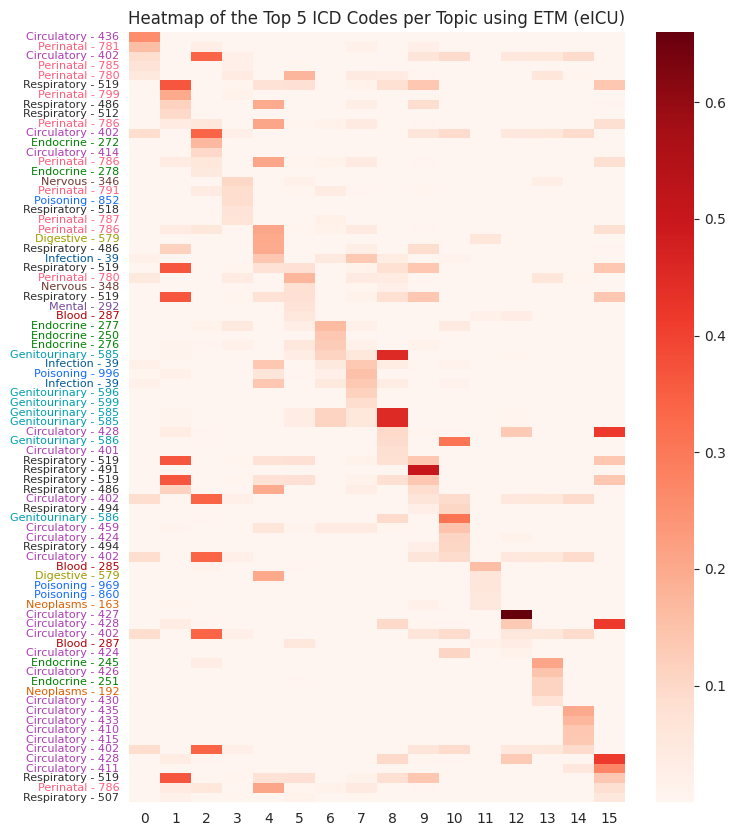

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

total_top_icd_idx = np.zeros((eicu_topic_word_distribution.shape[0], 5))  # K x 5

for topic in range(eicu_topic_word_distribution.shape[0]):
    topic_icds = eicu_topic_word_distribution[topic, :]
    top_icd_idx = np.flip(np.argsort(topic_icds))[:5]  # Top 5 ICD codes
    total_top_icd_idx[topic] = top_icd_idx

total_top_icd_idx = np.ravel(total_top_icd_idx).astype(int)

eicu_total_top_icd = eicu_topic_word_distribution[:, total_top_icd_idx]
eicu_total_top_icd = eicu_total_top_icd.T

total_top_icd_names = icd_code_names[total_top_icd_idx]
disease = [convert_icd9_to_disease(x) for x in total_top_icd_names]
disease_label = [f"{disease[i]} - {total_top_icd_names[i]}" for i in range(len(disease))]

plt.figure(figsize=(8, 10))

# Plot heatmap
plt.title("Heatmap of the Top 5 ICD Codes per Topic using ETM (eICU)")
ax = sns.heatmap(eicu_total_top_icd,
            yticklabels=disease_label,
            cmap='Reds')

ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

y_labels = plt.gca().get_yticklabels()
for i, label in enumerate(y_labels):
    color = disease_color_map[disease[i]]
    label.set_color(color)
    

plt.show()

In [15]:
from sklearn.decomposition import LatentDirichletAllocation

mimic_train_icds = train_icds[2001]
mimic_lda = LatentDirichletAllocation(n_components=16, random_state=42)
mimic_lda.fit(mimic_train_icds)

mimic_topic_word_distribution = mimic_lda.components_
mimic_topic_word_distribution = mimic_topic_word_distribution / mimic_topic_word_distribution.sum(axis=1)[:, np.newaxis]

mimic_x_bow_test = x_bow_tests[2001]
mimic_coherence = get_topic_coherence(mimic_topic_word_distribution, mimic_x_bow_test, 5)
mimic_diversity = get_topic_diversity(mimic_topic_word_distribution, 5)
mimic_quality = mimic_coherence * mimic_diversity

print("mimic ETM Topic Coherence: ", mimic_coherence)
print("mimic ETM Topic Diversity: ", mimic_diversity)
print("mimic ETM Topic Quality: ", mimic_quality)

mimic ETM Topic Coherence:  0.5055195134821433
mimic ETM Topic Diversity:  0.6875
mimic ETM Topic Quality:  0.3475446655189735


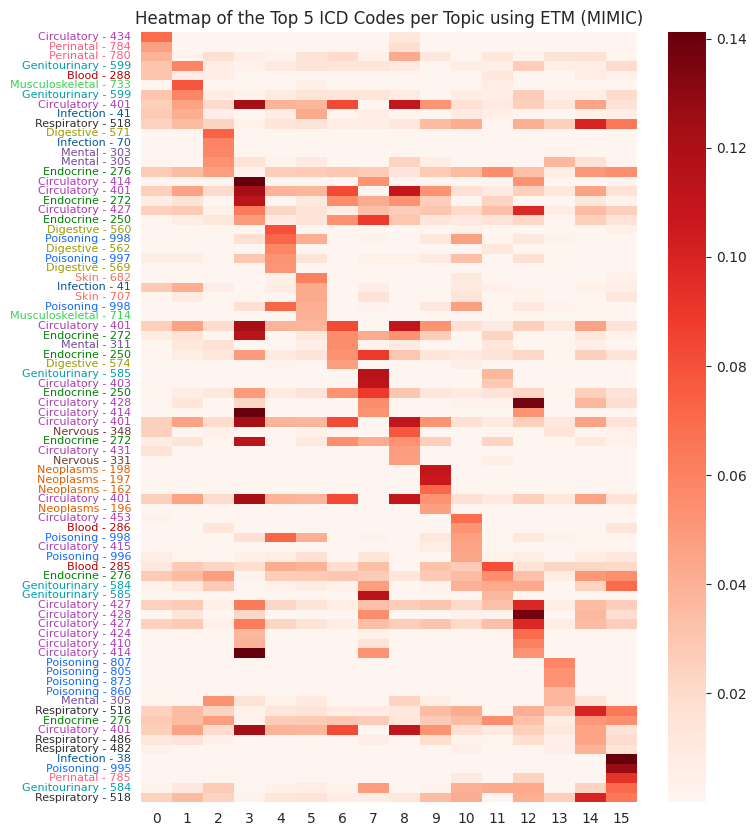

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

total_top_icd_idx = np.zeros((mimic_topic_word_distribution.shape[0], 5))  # K x 5

for topic in range(mimic_topic_word_distribution.shape[0]):
    topic_icds = mimic_topic_word_distribution[topic, :]
    top_icd_idx = np.flip(np.argsort(topic_icds))[:5]  # Top 5 ICD codes
    total_top_icd_idx[topic] = top_icd_idx

total_top_icd_idx = np.ravel(total_top_icd_idx).astype(int)

mimic_total_top_icd = mimic_topic_word_distribution[:, total_top_icd_idx]
mimic_total_top_icd = mimic_total_top_icd.T

total_top_icd_names = icd_code_names[total_top_icd_idx]
disease = [convert_icd9_to_disease(x) for x in total_top_icd_names]
disease_label = [f"{disease[i]} - {total_top_icd_names[i]}" for i in range(len(disease))]

plt.figure(figsize=(8, 10))

# Plot heatmap
plt.title("Heatmap of the Top 5 ICD Codes per Topic using ETM (MIMIC)")
ax = sns.heatmap(mimic_total_top_icd,
            yticklabels=disease_label,
            cmap='Reds')

ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

y_labels = plt.gca().get_yticklabels()
for i, label in enumerate(y_labels):
    color = disease_color_map[disease[i]]
    label.set_color(color)
    

plt.show()

## Topic: 32

In [17]:
from sklearn.decomposition import LatentDirichletAllocation

eicu_train_icds = train_icds[1001]
eicu_lda = LatentDirichletAllocation(n_components=32, random_state=42)
eicu_lda.fit(eicu_train_icds)

eicu_topic_word_distribution = eicu_lda.components_
eicu_topic_word_distribution = eicu_topic_word_distribution / eicu_topic_word_distribution.sum(axis=1)[:, np.newaxis]

eicu_x_bow_test = x_bow_tests[1001]
eicu_coherence = get_topic_coherence(eicu_topic_word_distribution, eicu_x_bow_test, 5)
eicu_diversity = get_topic_diversity(eicu_topic_word_distribution, 5)
eicu_quality = eicu_coherence * eicu_diversity

print("eICU ETM Topic Coherence: ", eicu_coherence)
print("eICU ETM Topic Diversity: ", eicu_diversity)
print("eICU ETM Topic Quality: ", eicu_quality)

eICU ETM Topic Coherence:  0.5013788921365472
eICU ETM Topic Diversity:  0.6375
eICU ETM Topic Quality:  0.3196290437370488


In [18]:
from sklearn.decomposition import LatentDirichletAllocation

mimic_train_icds = train_icds[2001]
mimic_lda = LatentDirichletAllocation(n_components=32, random_state=42)
mimic_lda.fit(mimic_train_icds)

mimic_topic_word_distribution = mimic_lda.components_
mimic_topic_word_distribution = mimic_topic_word_distribution / mimic_topic_word_distribution.sum(axis=1)[:, np.newaxis]

mimic_x_bow_test = x_bow_tests[2001]
mimic_coherence = get_topic_coherence(mimic_topic_word_distribution, mimic_x_bow_test, 5)
mimic_diversity = get_topic_diversity(mimic_topic_word_distribution, 5)
mimic_quality = mimic_coherence * mimic_diversity

print("mimic ETM Topic Coherence: ", mimic_coherence)
print("mimic ETM Topic Diversity: ", mimic_diversity)
print("mimic ETM Topic Quality: ", mimic_quality)

mimic ETM Topic Coherence:  0.5025617344031148
mimic ETM Topic Diversity:  0.68125
mimic ETM Topic Quality:  0.34237018156212196


## Topic: 64

In [19]:
from sklearn.decomposition import LatentDirichletAllocation

eicu_train_icds = train_icds[1001]
eicu_lda = LatentDirichletAllocation(n_components=64, random_state=42)
eicu_lda.fit(eicu_train_icds)

eicu_topic_word_distribution = eicu_lda.components_
eicu_topic_word_distribution = eicu_topic_word_distribution / eicu_topic_word_distribution.sum(axis=1)[:, np.newaxis]

eicu_x_bow_test = x_bow_tests[1001]
eicu_coherence = get_topic_coherence(eicu_topic_word_distribution, eicu_x_bow_test, 5)
eicu_diversity = get_topic_diversity(eicu_topic_word_distribution, 5)
eicu_quality = eicu_coherence * eicu_diversity

print("eICU ETM Topic Coherence: ", eicu_coherence)
print("eICU ETM Topic Diversity: ", eicu_diversity)
print("eICU ETM Topic Quality: ", eicu_quality)

eICU ETM Topic Coherence:  0.49966360020703626
eICU ETM Topic Diversity:  0.59375
eICU ETM Topic Quality:  0.29667526262292776


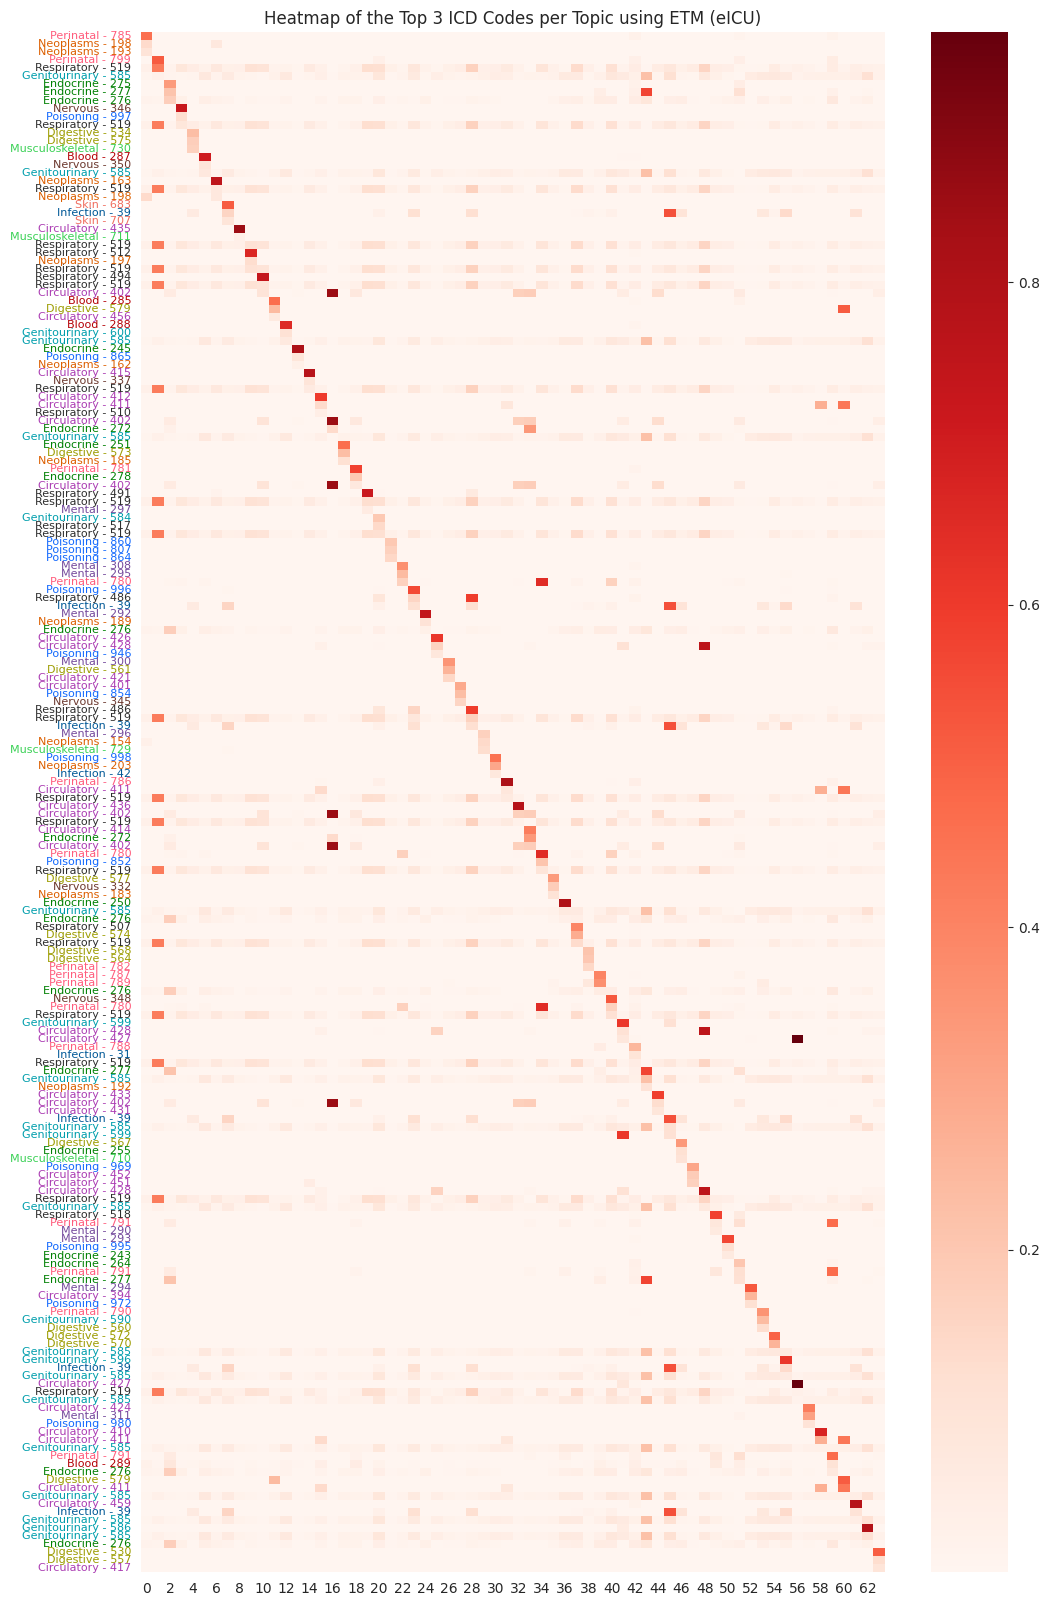

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

total_top_icd_idx = np.zeros((eicu_topic_word_distribution.shape[0], 3))  # K x 5

for topic in range(eicu_topic_word_distribution.shape[0]):
    topic_icds = eicu_topic_word_distribution[topic, :]
    top_icd_idx = np.flip(np.argsort(topic_icds))[:3]  # Top 5 ICD codes
    total_top_icd_idx[topic] = top_icd_idx

total_top_icd_idx = np.ravel(total_top_icd_idx).astype(int)

eicu_total_top_icd = eicu_topic_word_distribution[:, total_top_icd_idx]
eicu_total_top_icd = eicu_total_top_icd.T

total_top_icd_names = icd_code_names[total_top_icd_idx]
disease = [convert_icd9_to_disease(x) for x in total_top_icd_names]
disease_label = [f"{disease[i]} - {total_top_icd_names[i]}" for i in range(len(disease))]

plt.figure(figsize=(12, 20))

# Plot heatmap
plt.title("Heatmap of the Top 3 ICD Codes per Topic using ETM (eICU)")
ax = sns.heatmap(eicu_total_top_icd,
            yticklabels=disease_label,
            cmap='Reds')

ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

y_labels = plt.gca().get_yticklabels()
for i, label in enumerate(y_labels):
    color = disease_color_map[disease[i]]
    label.set_color(color)
    

plt.show()

In [21]:
from sklearn.decomposition import LatentDirichletAllocation

mimic_train_icds = train_icds[2001]
mimic_lda = LatentDirichletAllocation(n_components=64, random_state=42)
mimic_lda.fit(mimic_train_icds)

mimic_topic_word_distribution = mimic_lda.components_
mimic_topic_word_distribution = mimic_topic_word_distribution / mimic_topic_word_distribution.sum(axis=1)[:, np.newaxis]

mimic_x_bow_test = x_bow_tests[2001]
mimic_coherence = get_topic_coherence(mimic_topic_word_distribution, mimic_x_bow_test, 5)
mimic_diversity = get_topic_diversity(mimic_topic_word_distribution, 5)
mimic_quality = mimic_coherence * mimic_diversity

print("mimic ETM Topic Coherence: ", mimic_coherence)
print("mimic ETM Topic Diversity: ", mimic_diversity)
print("mimic ETM Topic Quality: ", mimic_quality)

mimic ETM Topic Coherence:  0.5006296830870985
mimic ETM Topic Diversity:  0.628125
mimic ETM Topic Quality:  0.31445801968908377


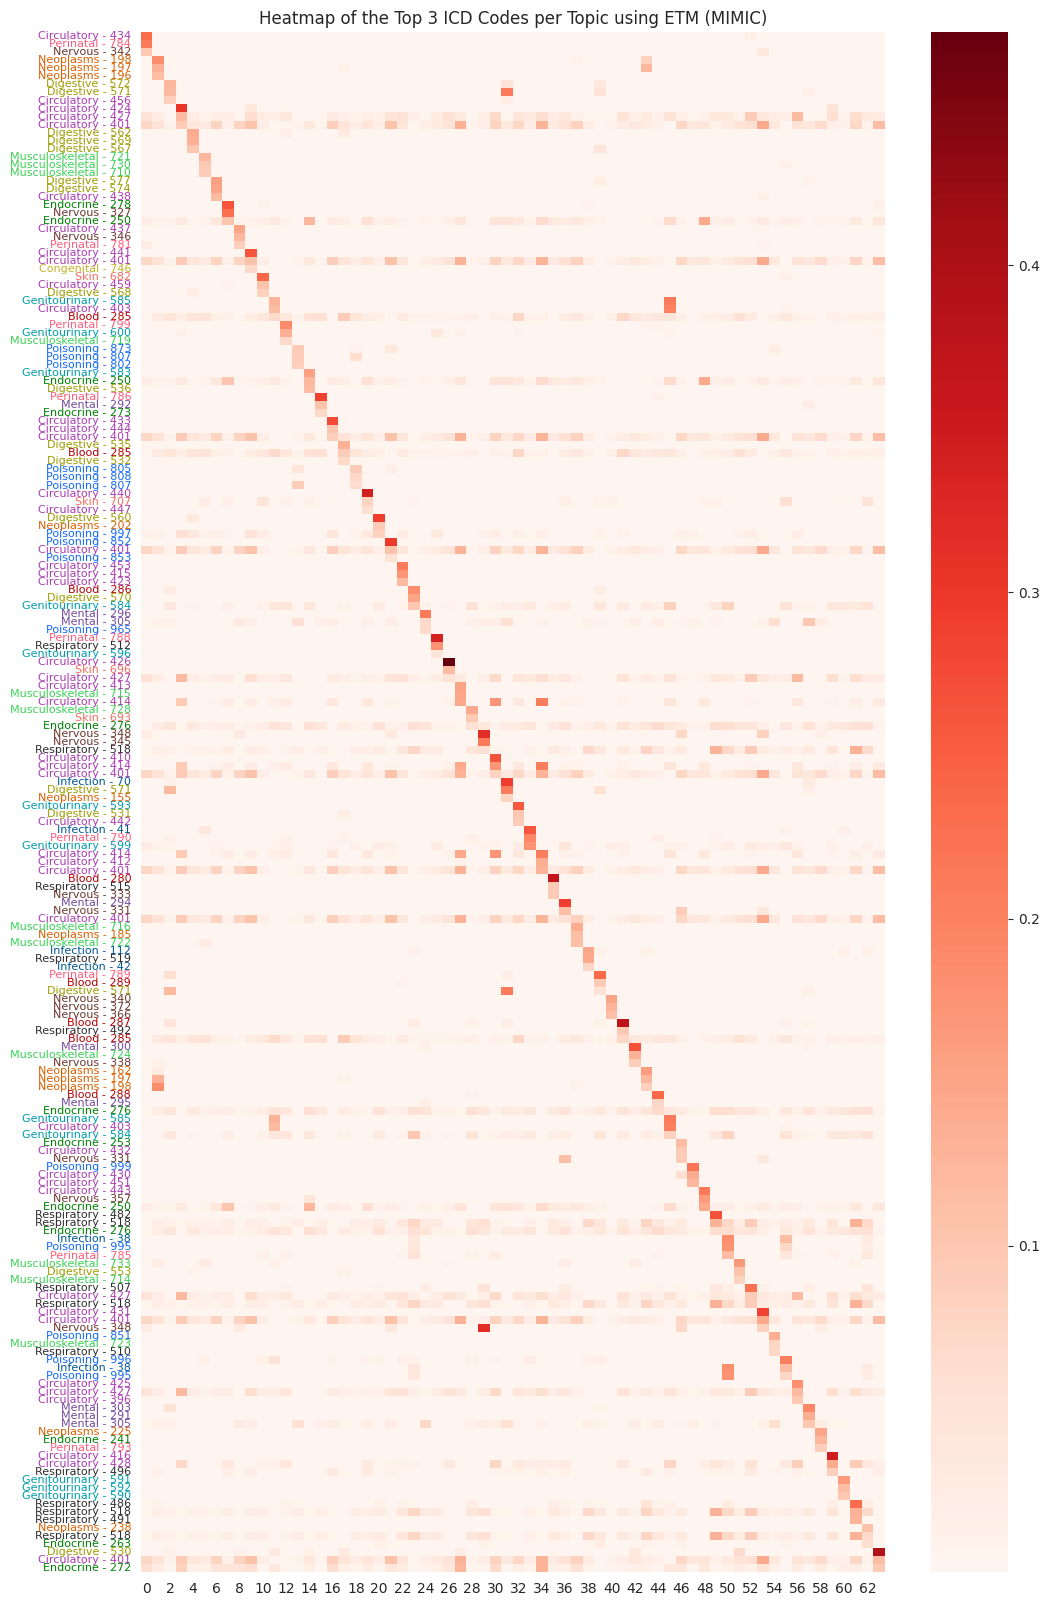

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

total_top_icd_idx = np.zeros((mimic_topic_word_distribution.shape[0], 3))  # K x 5

for topic in range(mimic_topic_word_distribution.shape[0]):
    topic_icds = mimic_topic_word_distribution[topic, :]
    top_icd_idx = np.flip(np.argsort(topic_icds))[:3]  # Top 5 ICD codes
    total_top_icd_idx[topic] = top_icd_idx

total_top_icd_idx = np.ravel(total_top_icd_idx).astype(int)

mimic_total_top_icd = mimic_topic_word_distribution[:, total_top_icd_idx]
mimic_total_top_icd = mimic_total_top_icd.T

total_top_icd_names = icd_code_names[total_top_icd_idx]
disease = [convert_icd9_to_disease(x) for x in total_top_icd_names]
disease_label = [f"{disease[i]} - {total_top_icd_names[i]}" for i in range(len(disease))]

plt.figure(figsize=(12, 20))

# Plot heatmap
plt.title("Heatmap of the Top 3 ICD Codes per Topic using ETM (MIMIC)")
ax = sns.heatmap(mimic_total_top_icd,
            yticklabels=disease_label,
            cmap='Reds')

ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

y_labels = plt.gca().get_yticklabels()
for i, label in enumerate(y_labels):
    color = disease_color_map[disease[i]]
    label.set_color(color)
    

plt.show()

In [23]:
np.sum(eicu_topic_word_distribution, axis=0)

array([5.81909691e-04, 3.48791202e-04, 1.08151551e-03, 1.94980452e-03,
       3.48791202e-04, 1.03648438e-01, 6.02129829e-02, 3.48791202e-04,
       5.44479117e-03, 3.48791202e-04, 3.48791202e-04, 3.48791202e-04,
       6.33909208e-04, 3.48791202e-04, 3.48791202e-04, 3.48791202e-04,
       9.40503124e-02, 6.83943968e-04, 3.48791202e-04, 3.48791202e-04,
       3.48791202e-04, 5.04014973e-04, 1.35424950e-03, 3.48791202e-04,
       1.52924138e+00, 3.48791202e-04, 1.52515553e-02, 7.56622878e-02,
       3.48791202e-04, 3.48791202e-04, 3.48791202e-04, 2.70274376e-03,
       3.48791202e-04, 9.17010074e-04, 3.48791202e-04, 3.48791202e-04,
       1.14170370e-02, 3.48791202e-04, 3.48791202e-04, 3.48791202e-04,
       1.26603172e-03, 3.89370478e-02, 1.09263928e-03, 5.61596228e-04,
       3.48791202e-04, 5.05669631e-03, 3.48791202e-04, 1.04729817e-03,
       3.48791202e-04, 3.48791202e-04, 3.48791202e-04, 4.92362102e-04,
       3.48791202e-04, 3.48791202e-04, 3.48791202e-04, 3.48791202e-04,
      

## Topic: 128

In [24]:
from sklearn.decomposition import LatentDirichletAllocation

eicu_train_icds = train_icds[1001]
eicu_lda = LatentDirichletAllocation(n_components=128, random_state=42)
eicu_lda.fit(eicu_train_icds)

eicu_topic_word_distribution = eicu_lda.components_
eicu_topic_word_distribution = eicu_topic_word_distribution / eicu_topic_word_distribution.sum(axis=1)[:, np.newaxis]

eicu_x_bow_test = x_bow_tests[1001]
eicu_coherence = get_topic_coherence(eicu_topic_word_distribution, eicu_x_bow_test, 5)
eicu_diversity = get_topic_diversity(eicu_topic_word_distribution, 5)
eicu_quality = eicu_coherence * eicu_diversity

print("eICU ETM Topic Coherence: ", eicu_coherence)
print("eICU ETM Topic Diversity: ", eicu_diversity)
print("eICU ETM Topic Quality: ", eicu_quality)

eICU ETM Topic Coherence:  0.49998376637571074
eICU ETM Topic Diversity:  0.3875
eICU ETM Topic Quality:  0.19374370947058792


In [25]:
from sklearn.decomposition import LatentDirichletAllocation

mimic_train_icds = train_icds[2001]
mimic_lda = LatentDirichletAllocation(n_components=128, random_state=42)
mimic_lda.fit(mimic_train_icds)

mimic_topic_word_distribution = mimic_lda.components_
mimic_topic_word_distribution = mimic_topic_word_distribution / mimic_topic_word_distribution.sum(axis=1)[:, np.newaxis]


mimic_x_bow_test = x_bow_tests[2001]
mimic_coherence = get_topic_coherence(mimic_topic_word_distribution, mimic_x_bow_test, 5)
mimic_diversity = get_topic_diversity(mimic_topic_word_distribution, 5)
mimic_quality = mimic_coherence * mimic_diversity

print("mimic ETM Topic Coherence: ", mimic_coherence)
print("mimic ETM Topic Diversity: ", mimic_diversity)
print("mimic ETM Topic Quality: ", mimic_quality)

mimic ETM Topic Coherence:  0.4998701973005223
mimic ETM Topic Diversity:  0.5203125
mimic ETM Topic Quality:  0.260088712032928


## Topic: 256

In [26]:
from sklearn.decomposition import LatentDirichletAllocation

eicu_train_icds = train_icds[1001]
eicu_lda = LatentDirichletAllocation(n_components=256, random_state=42)
eicu_lda.fit(eicu_train_icds)

eicu_topic_word_distribution = eicu_lda.components_
eicu_topic_word_distribution = eicu_topic_word_distribution / eicu_topic_word_distribution.sum(axis=1)[:, np.newaxis]

eicu_x_bow_test = x_bow_tests[1001]
eicu_coherence = get_topic_coherence(eicu_topic_word_distribution, eicu_x_bow_test, 5)
eicu_diversity = get_topic_diversity(eicu_topic_word_distribution, 5)
eicu_quality = eicu_coherence * eicu_diversity

print("eICU ETM Topic Coherence: ", eicu_coherence)
print("eICU ETM Topic Diversity: ", eicu_diversity)
print("eICU ETM Topic Quality: ", eicu_quality)

eICU ETM Topic Coherence:  0.5000743358067004
eICU ETM Topic Diversity:  0.2265625
eICU ETM Topic Quality:  0.11329809170620556


In [27]:
from sklearn.decomposition import LatentDirichletAllocation

mimic_train_icds = train_icds[2001]
mimic_lda = LatentDirichletAllocation(n_components=256, random_state=42)
mimic_lda.fit(mimic_train_icds)

mimic_topic_word_distribution = mimic_lda.components_
mimic_topic_word_distribution = mimic_topic_word_distribution / mimic_topic_word_distribution.sum(axis=1)[:, np.newaxis]

mimic_x_bow_test = x_bow_tests[2001]
mimic_coherence = get_topic_coherence(mimic_topic_word_distribution, mimic_x_bow_test, 5)
mimic_diversity = get_topic_diversity(mimic_topic_word_distribution, 5)
mimic_quality = mimic_coherence * mimic_diversity

print("mimic ETM Topic Coherence: ", mimic_coherence)
print("mimic ETM Topic Diversity: ", mimic_diversity)
print("mimic ETM Topic Quality: ", mimic_quality)

mimic ETM Topic Coherence:  0.4999973741975526
mimic ETM Topic Diversity:  0.36953125
mimic ETM Topic Quality:  0.18476465468393935


In [28]:
mimic_train_icds.shape

(31099, 849)

In [29]:
eicu_train_icds.shape

(94342, 849)